In [1]:
import torch
import joblib
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cyvcf2 import VCF, Writer
from vcf_helpers import extract_variant_features, normalize_vcf_features_for_prediction, determine_tumor_sample_index
from sklearn.metrics import precision_score, recall_score

In [2]:
# === Load model and scaler ===
class FeedforwardNet(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(64, 32),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(32, 1),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

In [3]:
# Load metadata
with open("model_metadata.json") as f:
    metadata = json.load(f)
top_features = metadata["features"]
threshold = metadata["threshold"]

In [4]:
# Load model and scaler
model = FeedforwardNet(input_dim=len(top_features))
model.load_state_dict(torch.load("final_nn_model.pt"))
model.eval()

FeedforwardNet(
  (model): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [5]:
# === Process new VCF ===
vcf_path = "validation_chr19.vcf"
vcf = VCF(vcf_path)
vcf.add_info_to_header({'ID': 'high_confidence', 'Description': 'Model prediction exceeds threshold', 'Type': 'String', 'Number': '1'})

0

In [6]:
# INFO and FORMAT fields to extract
info_fields = [
    "MBQ", "MMQ", "GOLDEN"
]

format_fields = [
    "AD", "AF", "F1R2", "F2R1"
]

split_ref_alt_fields = {"AD", "AF", "F1R2", "F2R1"}
split_info_ref_alt = {"MBQ", "MMQ"}

In [7]:
tumor_index = determine_tumor_sample_index(vcf.samples)

Using tumor sample: chr19.tumor.snv.indel


In [8]:
df = extract_variant_features(vcf, info_fields, format_fields, split_info_ref_alt, split_ref_alt_fields, tumor_index)

In [9]:
df = normalize_vcf_features_for_prediction(df, robust_scaler_path="robust_scaler.pkl")

In [10]:
# Predict
X = df[top_features].values.astype(np.float32)
probs = model(torch.tensor(X)).squeeze().detach().numpy()
df["probability"] = probs
df["high_confidence"] = (df["probability"] >= threshold).astype(int)

In [11]:
precision = precision_score(df['GOLDEN'].fillna(0).astype(int), df['high_confidence'].astype(int))
recall = recall_score(df['GOLDEN'].fillna(0).astype(int), df['high_confidence'].astype(int))

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 0.3714
Recall: 0.0483


In [12]:
count = (df['probability'] > threshold).sum()
print(f"Number of rows where 'probability' > {threshold}: {count}")

print(df['probability'].describe())

Number of rows where 'probability' > 0.24123049030701318: 35
count    2.081600e+04
mean     1.074752e-02
std      2.172421e-02
min      9.147229e-12
25%      2.080868e-07
50%      2.764550e-03
75%      1.213699e-02
max      4.554917e-01
Name: probability, dtype: float64


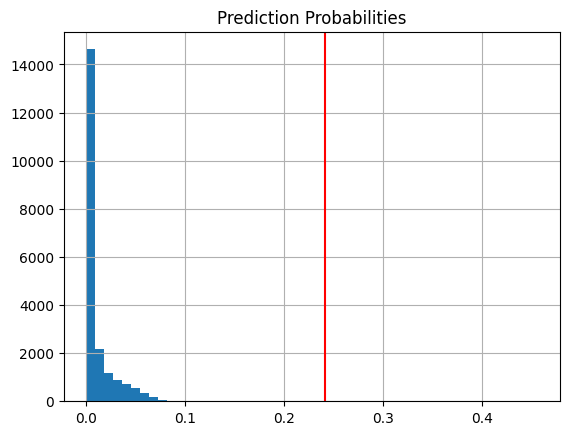

In [13]:
df["probability"].hist(bins=50)
plt.axvline(threshold, color="red")
plt.title("Prediction Probabilities")
plt.show()